In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("svg")
from sklearn.decomposition import PCA
import torchvision
import torchvision.transforms as T

In [6]:
mnist_train = torchvision.datasets.MNIST("../data", train=True, download=True, transform=T.Compose((T.ToTensor(), torch.flatten)))
mnist_test = torchvision.datasets.MNIST("../data", train=False, download=False, transform=T.Compose((T.ToTensor(), torch.flatten)))

data = np.array([x[0] for x in mnist_train])
data_T = torch.tensor(data).float()

In [9]:
def create_mnist_model():
    class MNISTAE(nn.Module):
        def __init__(self, *args, **kwargs) -> None:
            super().__init__(*args, **kwargs)
            self.input = nn.Linear(784, 150)
            self.enc = nn.Linear(150, 15)
            self.lat = nn.Linear(15, 150)
            self.dec = nn.Linear(150, 784)
        def forward(self, x):
            x = torch.relu(self.input(x))
            codex = torch.relu(self.enc(x)) # this way we can export output of a hidden layer also
            x = torch.relu(self.lat(codex))
            y = torch.sigmoid(self.dec(x))
            return y, codex
    net = MNISTAE()
    lossfunc = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=.001)
    return net, lossfunc, optimizer

In [11]:
batch_size = 32
epochs = 5
import sys
def train_model():
    net, lossfunc, optimizer = create_mnist_model()
    losses = [None] * epochs
    for ei in range(epochs):
        for i in range(int(data_T.shape[0]/batch_size)):
            x = data_T[i*batch_size:i*batch_size+batch_size]
            y = net(x)[0]
            loss = lossfunc(y, x)
            losses[ei] = loss.detach().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        sys.stdout.write("\r" + f"Epoch {ei+1}/{epochs}")
    return net, losses

In [12]:
net, losses = train_model()

Epoch 5/5

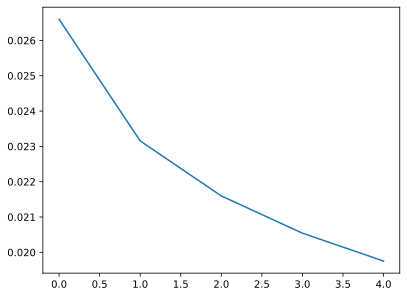

In [13]:
plt.plot(losses)
plt.show()

In [14]:
net.eval()
y_pred, latent_code = net(data_T)
net.train()

MNISTAE(
  (input): Linear(in_features=784, out_features=150, bias=True)
  (enc): Linear(in_features=150, out_features=15, bias=True)
  (lat): Linear(in_features=15, out_features=150, bias=True)
  (dec): Linear(in_features=150, out_features=784, bias=True)
)

In [15]:
y_pred.shape, latent_code.shape

(torch.Size([60000, 784]), torch.Size([60000, 15]))

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].hist(latent_code.flatten().detach(), 100)
ax[0].set_xlabel("Latent activation value")
ax[0]